![alt text](./../../img/adaptive_rag.png)

In [9]:
# 표준 라이브러리
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain import hub

load_dotenv()


True

In [2]:
class AgentState(TypedDict):
    query: str
    context: List
    answer: str


In [3]:
prompt = hub.pull("rlm/rag-prompt")
generate_prompt = hub.pull("rlm/rag-prompt")
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

In [4]:
MODEL_NAME = "gemma2-9b-it"



# 이미 생성된 크로마 db 가져오기
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)


vector_store = Chroma(
    embedding_function=embeddings_model,
    collection_name = "income_tax_collection",
    persist_directory = "./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs = {"k":3})

C:\Users\user\AppData\Local\Temp\ipykernel_16496\3184129235.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(
c:\USERS\USER\DESKTOP\FINBRAINAGENT\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# 지금은 모두 동일한 모델 사용
# 하지만 간단한 대답이 필요할 때는 저렴한 모델로 비용 아끼자
# 습관을 위해 일단 나눔

generate_llm = ChatGroq(model_name=MODEL_NAME)
basic_llm =ChatGroq(model_name=MODEL_NAME)

In [43]:
tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    print(f"web_search_results == {results}")
    return {"context": results}


def web_generate(state: AgentState):

    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}


In [44]:
def basic_generate(state: AgentState):
    query = state["query"]
    basic_llm_chain = basic_llm | StrOutputParser()
    response = basic_llm_chain.invoke(query)
    return {"answer" : response}



## query analysic

In [45]:
from pydantic import BaseModel, Field


In [46]:
class Route(BaseModel):
    target : Literal["vector_store", "llm", "web_search"] = Field(description="the target for the query to answer")


In [47]:
router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

# 간단한 테스크 -> 저렴한 모델 사용해도 무방 
router_llm = ChatGroq(model_name=MODEL_NAME)
structured_router_llm = router_llm.with_structured_output(Route)


router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "{query}"),
])
def router(state: AgentState):
    query = state["query"]
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({"query": query})
    print(f"route == {route}")
    print(f"route.target == {route.target}")
    return route.target


In [48]:
from income_tax_graph import graph as income_tax_subgraph


In [49]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("web_search", web_search)
graph_builder.add_node("basic_generate", basic_generate)
graph_builder.add_node("web_generate", web_generate)
graph_builder.add_node("income_tax_subgraph", income_tax_subgraph)

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "vector_store": "income_tax_subgraph",
        "llm": "basic_generate",
        "web_search": "web_search",
    }
)

graph_builder.add_edge("web_search", "web_generate")
graph_builder.add_edge("income_tax_subgraph", END)
graph_builder.add_edge("web_generate", END)
graph_builder.add_edge("basic_generate", END)



graph = graph_builder.compile()


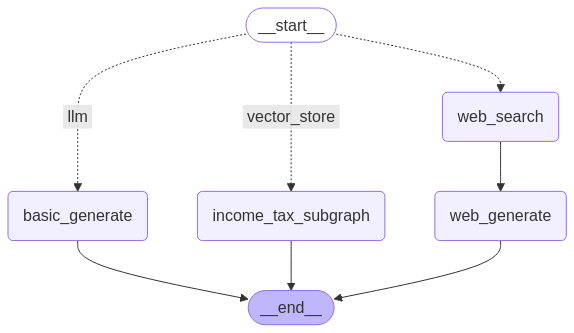

In [50]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph(xray=False).draw_mermaid_png()
    )
)


In [40]:
initial_state = {"query": "신대방역 맛집 추천해라"}

graph.invoke(initial_state)


route == target='web_search'
route.target == web_search
web_search_results == [{'url': 'https://www.diningcode.com/list.dc?query=%EC%8B%A0%EB%8C%80%EB%B0%A9%EC%97%AD', 'content': '신대방역맛집 (305곳) · 1. 등나무집 신대방 · 2. 사생활 카페 신림 · 3. 한마음정육식당 서울 신대방점 · 4. 서우얼큰칼국수 신대방역 · 5. Hoang hon 베트남쌀국수 신대방역.'}, {'url': 'https://m.blog.naver.com/god10043179/223100468242', 'content': '가성비 ; 육회비빔밥. 10000원 ; 육회냉면. 12000원 ; 연어초밥. 15000원.'}, {'url': 'https://blog.naver.com/chansxor1/221917094627', 'content': '신대방삼거리역에서 5분정도 거리이고 버스정류장하고도 1분남짓한 가까운 거리에 있기때문에 접근성이 굉장히 편리한 곳이에요. 도착해보니 향토적인'}]


{'query': '신대방역 맛집 추천해라',
 'context': [{'url': 'https://www.diningcode.com/list.dc?query=%EC%8B%A0%EB%8C%80%EB%B0%A9%EC%97%AD',
   'content': '신대방역맛집 (305곳) · 1. 등나무집 신대방 · 2. 사생활 카페 신림 · 3. 한마음정육식당 서울 신대방점 · 4. 서우얼큰칼국수 신대방역 · 5. Hoang hon 베트남쌀국수 신대방역.'},
  {'url': 'https://m.blog.naver.com/god10043179/223100468242',
   'content': '가성비 ; 육회비빔밥. 10000원 ; 육회냉면. 12000원 ; 연어초밥. 15000원.'},
  {'url': 'https://blog.naver.com/chansxor1/221917094627',
   'content': '신대방삼거리역에서 5분정도 거리이고 버스정류장하고도 1분남짓한 가까운 거리에 있기때문에 접근성이 굉장히 편리한 곳이에요. 도착해보니 향토적인'}],
 'answer': '신대방역에서 가까운 곳에 위치한 맛집으로는 등나무집 신대방, 사생활 카페 신림, 한마음정육식당 서울 신대방점, 서우얼큰칼국수 신대방역, Hoang hon 베트남쌀국수 신대방역이 있습니다. 육회비빔밥, 육회냉면, 연어초밥 등도 추천합니다. \n'}

In [51]:
initial_state = {"query": "대한민국 수도"}

graph.invoke(initial_state)


route == target='llm'
route.target == llm


{'query': '대한민국 수도', 'answer': '대한민국 수도는 **서울**입니다. \n'}

In [52]:
initial_state = {"query": "연봉 3000만원 거주자 소득세 얼마냐"}

graph.invoke(initial_state)


route == target='vector_store'
route.target == vector_store
context == [Document(id='cff0738b-e15c-47e3-9366-61e7083d9819', metadata={'source': './documents/income_tax.txt'}, page_content='제59조의3(연금계좌세액공제) ① 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 다음 각 호에 해당하는 금액을 제외한 금액(이하 "연금계좌 납입액"이라 한다) 중 100분의 12에 해당하는 과세기간에 종합소득세표준을 계산할 때 한산하는 종합소득금액이 4천500만원 이하(근로소득이 있는 경우에는 종합소득금액이 5천500만원 이하)에 대해서는 100분의 15에 해당하는 금액을 해당 과세기간의 종합소득세산출세액에서 공제한다. 다만, 연금계좌 중 연금주계좌에 납입한 금액이 연 600만원을 초과하는 경우에는 초과하는 금액은 그 금액으로 하고, 연금주계좌에 납입한 금액 중 600만원 이내의 금액과 기타연금계좌에 납입한 금액을 합한 금액이 연 900만원을 초과하는 경우에는 그 초과하는 금액은 금액으로 하는 것으 로 한다. <개정 2014. 12. 31.>\n1. 제146조제28항에 따른 소득세 원천징수대상이 아닌 퇴직소득 등 기타 예외 소득\n2. 연금계좌에 따른 연금계좌세액공제는 납입된 금액\n③ 제1항에 따른 공제는 "연금계좌세액공제"라 한다.\n④ "조세특례제한법", 제59조의18에 따른 기금이행자산관리계약이 만료되고 해당 계좌 잔여의 종류도 일정한 방법으로 정하는 방법으로 연금계좌에 납입한 금액(이하 이 조에서 "전환금"이라 한다)을 납입한 법인 또는 실속있는 방법으로 연금계좌의 납입액을 포함한다. <신설 2019. 12. 31.>\n⑤ 전환금이 있는 경우 제1항 각 호의 부분 구분에서 불가피한 경우 한정 적용 할 전환금의 100분의 10을 초과하는 경우 제2항 각 호에 기한 연금계좌 세액에 발생한 금액에 대하여 차감하는 금액을

{'query': '연봉 3000만원 거주자 소득세 얼마냐',
 'context': [Document(id='cff0738b-e15c-47e3-9366-61e7083d9819', metadata={'source': './documents/income_tax.txt'}, page_content='제59조의3(연금계좌세액공제) ① 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 다음 각 호에 해당하는 금액을 제외한 금액(이하 "연금계좌 납입액"이라 한다) 중 100분의 12에 해당하는 과세기간에 종합소득세표준을 계산할 때 한산하는 종합소득금액이 4천500만원 이하(근로소득이 있는 경우에는 종합소득금액이 5천500만원 이하)에 대해서는 100분의 15에 해당하는 금액을 해당 과세기간의 종합소득세산출세액에서 공제한다. 다만, 연금계좌 중 연금주계좌에 납입한 금액이 연 600만원을 초과하는 경우에는 초과하는 금액은 그 금액으로 하고, 연금주계좌에 납입한 금액 중 600만원 이내의 금액과 기타연금계좌에 납입한 금액을 합한 금액이 연 900만원을 초과하는 경우에는 그 초과하는 금액은 금액으로 하는 것으 로 한다. <개정 2014. 12. 31.>\n1. 제146조제28항에 따른 소득세 원천징수대상이 아닌 퇴직소득 등 기타 예외 소득\n2. 연금계좌에 따른 연금계좌세액공제는 납입된 금액\n③ 제1항에 따른 공제는 "연금계좌세액공제"라 한다.\n④ "조세특례제한법", 제59조의18에 따른 기금이행자산관리계약이 만료되고 해당 계좌 잔여의 종류도 일정한 방법으로 정하는 방법으로 연금계좌에 납입한 금액(이하 이 조에서 "전환금"이라 한다)을 납입한 법인 또는 실속있는 방법으로 연금계좌의 납입액을 포함한다. <신설 2019. 12. 31.>\n⑤ 전환금이 있는 경우 제1항 각 호의 부분 구분에서 불가피한 경우 한정 적용 할 전환금의 100분의 10을 초과하는 경우 제2항 각 호에 기한 연금계좌 세액에 발생한 금액에 대하여 차감하는 금액을 총 중간계좌 세액이 제1항 각 호에 해당 